Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.5049 - loss: 0.0305 - val_accuracy: 0.5075 - val_loss: 0.0087
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5112 - loss: 0.0078 - val_accuracy: 0.5080 - val_loss: 0.0059
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5105 - loss: 0.0057 - val_accuracy: 0.5080 - val_loss: 0.0049
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5087 - loss: 0.0048 - val_accuracy: 0.5081 - val_loss: 0.0043
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5111 - loss: 0.0044 - val_accuracy: 0.5081 - val_loss: 0.0043
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5115 - loss: 0.0041 - val_accuracy: 0.5081 - val_loss: 0.0037
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5097 - loss: 0.0038 - val_accuracy: 0.5081 - val_loss: 0.0035
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5110 - loss: 0.0035 - val_accuracy: 0

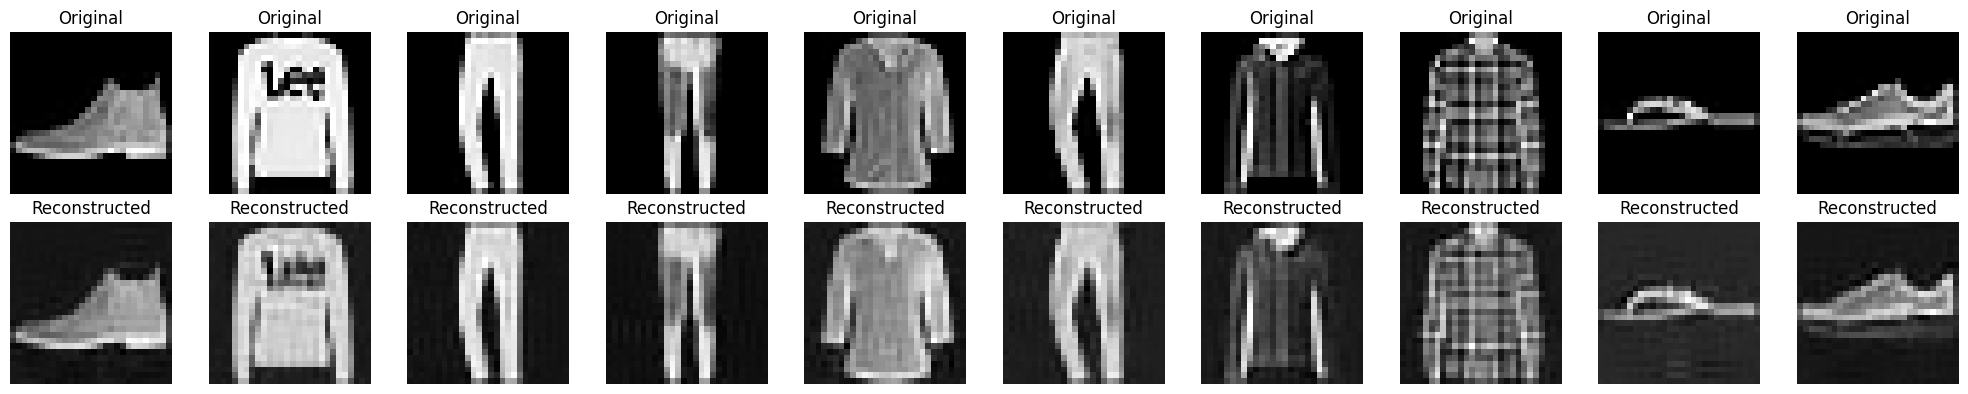

In [2]:
from keras import layers, models, datasets, backend
import numpy as np
import matplotlib.pyplot as plt
import keras

def Conv2D(filters, kernel_size, padding='same', activation='relu'):
    return layers.Conv2D(filters, kernel_size, padding=padding, activation=activation)

# ---------------------------
# AutoEncoder 정의
# ---------------------------
class AE(models.Model):
    def __init__(self, org_shape=(28, 28, 1)):
        original = layers.Input(shape=org_shape)

        # Encoder
        x = Conv2D(32, (3, 3))(original)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(64, (3, 3))(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
        z = Conv2D(128, (3, 3), padding='same')(x)

        # Decoder
        y = Conv2D(64, (3, 3), activation='relu', padding='same')(z)
        y = layers.UpSampling2D((2, 2))(y)
        y = Conv2D(32, (3, 3), activation='relu', padding='same')(y)
        y = layers.UpSampling2D((2, 2))(y)

        # Output: linear + MSE (복원 문제)
        decoded = Conv2D(1, (3, 3), activation='linear', padding='same')(y)

        super().__init__(original, decoded)
        self.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


# ---------------------------
# 데이터 로드 (Fashion-MNIST)
# ---------------------------
class DATA():
    def __init__(self):
        num_classes = 10

        # Fashion-MNIST
        (x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()
        img_rows, img_cols = x_train.shape[1:]

        # 형상 변환
        if backend.image_data_format() == 'channels_first':
            x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
            x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
            input_shape = (1, img_rows, img_cols)
        else:
            x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
            x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
            input_shape = (img_rows, img_cols, 1)

        # 정규화
        x_train = x_train.astype('float32') / 255.0
        x_test = x_test.astype('float32') / 255.0

        # 원-핫 인코딩 (필요 시)
        y_train = keras.utils.to_categorical(y_train, num_classes)
        y_test = keras.utils.to_categorical(y_test, num_classes)

        # 데이터 보관
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.x_train, self.y_train = x_train, y_train
        self.x_test, self.y_test = x_test, y_test


# ---------------------------
# 결과 시각화
# ---------------------------
def show_ae(autoencoder, data):
    x_test = data.x_test
    decoded_imgs = autoencoder.predict(x_test)
    print(decoded_imgs.shape, data.x_test.shape)

    if backend.image_data_format() == 'channels_first':
        N, n_ch, n_i, n_j = x_test.shape
    else:
        N, n_i, n_j, n_ch = x_test.shape

    x_test = x_test.reshape(N, n_i, n_j)
    decoded_imgs = decoded_imgs.reshape(decoded_imgs.shape[0], n_i, n_j)

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i], cmap='gray')
        ax.set_title("Original")
        ax.axis('off')

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i], cmap='gray')
        ax.set_title("Reconstructed")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


# ---------------------------
# 실행 (학습 및 시각화)
# ---------------------------
def main(epochs=20, batch_size=128):
    data = DATA()
    ae = AE(data.input_shape)

    history = ae.fit(
        data.x_train, data.x_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        validation_split=0.2,
        verbose=1
    )

    show_ae(ae, data)

if __name__ == "__main__":
    main()
